# 1. Data preprocessing & Model building



In [ ]:
!pip install keras-tuner -q

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!wget --no-check-certificate \
#    "https://github.com/prajnasb/obatch_sizeervations/archive/refs/heads/master.zip" \
#    -O "/tmp/obatch_sizeervations.zip"


#zip_ref = zipfile.ZipFile('/tmp/obatch_sizeervations.zip', 'r') #Opens the zip file in read mode
#zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
#zip_ref.close()

In [ ]:
lr = 1e-3
epoch = 30 #25,35,40
batch_size = 16 

DIRECTORY = "/content/drive/My Drive/FaceMaskDetection-main/FaceMaskDetection-main/data/data/" #C:\Python\FaceMaskDetection-main\FaceMaskDetection-main\data
TEST = "/content/drive/My Drive/face_mask_test/test_images/"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [ ]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))    #299, 299 : inceptionresnetv2
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
(x_train, x_test, y_train, y_test) = train_test_split(data, labels,
	test_size=0.10, stratify=labels, random_state=42)

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
  vertical_flip = True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


#baseModel = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=Input(shape=(299, 299, 3)))

#baseModel = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_tensor=Input(shape=(299,299,3)), classifier_activation="softmax") #classes=1000

In [ ]:

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)  
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# freezw the base model during training
for layer in baseModel.layers:
	layer.trainable = False            #true: fine tuning whole model

In [ ]:
def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# compile our model
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
opt = Adam(learning_rate=lr, decay=lr / epoch)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])      

# 1.1 Keras Tuner

In [ ]:
from tensorflow.keras import layers
from keras_tuner import RandomSearch


def build_model(hp):
    baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    for layer in baseModel.layers:
	    layer.trainable = False
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(hp.Choice("rate", values=[0.3,0.5]))(headModel)  
    headModel = Dense(2, activation="softmax")(headModel)


    model = Model(inputs=baseModel.input, outputs=headModel)
  
    model.compile(loss="binary_crossentropy", optimizer=Adam(hp.Choice("learning_rate", values=[4e-4, 1e-3, 1e-4])), metrics=["accuracy"])      
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True) #directory="my_dir",project_name="helloworld",

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
tuner.search(x_train, y_train, epochs=2, validation_data=(x_test, y_test))

Trial 3 Complete [00h 02m 42s]
val_accuracy: 0.97826087474823

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 08m 20s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
rate: 0.3
learning_rate: 0.0004
Score: 1.0
Trial summary
Hyperparameters:
rate: 0.3
learning_rate: 0.001
Score: 1.0
Trial summary
Hyperparameters:
rate: 0.3
learning_rate: 0.0001
Score: 0.97826087474823


# 2. Model training after optimization of hyperparameters

<font size =5, font color ='yellow'> a) MobileNet

Best value: lr = 0.01 dropout rate = 0.3

In [ ]:
# train the head of the network

H = model.fit(aug.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) // batch_size, validation_data=(x_test, y_test), validation_steps=len(x_test) // batch_size, callbacks=[callback],
	epochs=epoch)

Epoch 1/30
77/77 [==============================] - 52s 635ms/step - loss: 0.1622 - accuracy: 0.9345 - val_loss: 0.0253 - val_accuracy: 0.9928
Epoch 2/30
77/77 [==============================] - 48s 622ms/step - loss: 0.0424 - accuracy: 0.9894 - val_loss: 0.0390 - val_accuracy: 0.9783
Epoch 3/30
77/77 [==============================] - 48s 623ms/step - loss: 0.0448 - accuracy: 0.9836 - val_loss: 0.0270 - val_accuracy: 0.9855
Epoch 4/30
77/77 [==============================] - 48s 624ms/step - loss: 0.0252 - accuracy: 0.9926 - val_loss: 0.0138 - val_accuracy: 0.9928
Epoch 5/30
77/77 [==============================] - 48s 625ms/step - loss: 0.0290 - accuracy: 0.9910 - val_loss: 0.0249 - val_accuracy: 0.9928
Epoch 6/30
77/77 [==============================] - 48s 625ms/step - loss: 0.0177 - accuracy: 0.9943 - val_loss: 0.0339 - val_accuracy: 0.9855
Epoch 7/30
77/77 [==============================] - 48s 625ms/step - loss: 0.0186 - accuracy: 0.9935 - val_loss: 0.0109 - val_accuracy: 1.0000

<font size =5, font color ='pink'> Model testing 

In [ ]:
tdata = []
tlabels = []

for category in CATEGORIES:
    path = os.path.join(TEST, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))  #299, 299 : inceptionresnetv2
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	tdata.append(image)
    	tlabels.append(category)
     

     
     #x_test is working!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(tdata, batch_size=batch_size)

In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(tlabels, predIdxs)

In [ ]:
print("Test accuracy: ", acc)

In [ ]:
import tensorflow as tf

# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
save_path = os.path.join(DIRECTORY, "mobilenet/")
model.save("face_mask_detector1.model", save_path) #tf.saved_model.save(model, save_path)
#model.save("face_mask_detector.model", save_format="h5")

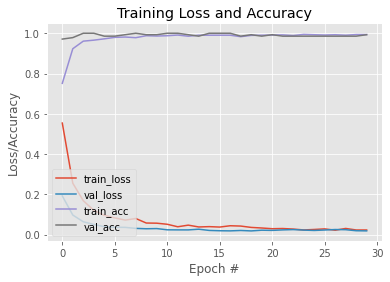

In [ ]:
# plot the training loss and accuracy
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# <font size =5, font color ='yellow'> b) InceptionResNetV2

In [ ]:
bm = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=Input(shape=(299, 299, 3)))

In [ ]:

hm = bm.output
hm = AveragePooling2D(pool_size=(7, 7))(hm)
hm = Flatten(name="flatten")(hm)
hm = Dense(128, activation="relu")(hm)
hm = Dropout(0.3)(hm)  
hm = Dense(2, activation="softmax")(hm)


model2 = Model(inputs=bm.input, outputs=hm)

In [ ]:
# freezw the base model during training
for layer in bm.layers:
	layer.trainable = False            #true: fine tuning whole model

In [ ]:
def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# compile our model
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
opt = Adam(learning_rate=lr, decay=lr / epoch)
model2.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])      

In [ ]:
# train the head of the network

H = model.fit(aug.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) // batch_size, validation_data=(x_test, y_test), validation_steps=len(x_test) // batch_size, callbacks=[callback],
	epochs=12)

<font size =5, font color ='pink'> Model testing

In [ ]:
tdata = []
tlabels = []

for category in CATEGORIES:
    path = os.path.join(TEST, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))  #299, 299 : inceptionresnetv2
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	tdata.append(image)
    	tlabels.append(category)

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(tdata, batch_size=batch_size)

In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
import tensorflow as tf

# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

save_path = os.path.join(DIRECTORY, "incepresnet/")
model.save("face_mask_detector2.model", save_path)
#model.save("face_mask_detector.model", save_format="h5")

# <font size =5, font color ='yellow'> c) InceptionV3

In [ ]:
baseModel = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_tensor=Input(shape=(299,299,3)), classifier_activation="softmax") #classes=1000

In [ ]:

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)  
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# freezw the base model during training
for layer in baseModel.layers:
	layer.trainable = False            #true: fine tuning whole model

In [ ]:
def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# compile our model
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
opt = Adam(learning_rate=lr, decay=lr / epoch)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])      

In [ ]:
# train the head of the network

H = model.fit(aug.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train) // batch_size, validation_data=(x_test, y_test), validation_steps=len(x_test) // batch_size, callbacks=[callback],
	epochs=12)

<font size =5, font color ='pink'> Model testing

In [ ]:
tdata = []
tlabels = []

for category in CATEGORIES:
    path = os.path.join(TEST, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))  #299, 299 : inceptionresnetv2
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	tdata.append(image)
    	tlabels.append(category)

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(tdata, batch_size=batch_size)

In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
import tensorflow as tf

# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

save_path = os.path.join(DIRECTORY, "incept/")
model.save("face_mask_detector3.model", save_path)
#model.save("face_mask_detector.model", save_format="h5")

# 3. Testing model on real-time data

In [ ]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os


In [ ]:

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            
            
            
            
            

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))
            
            
            

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [ ]:
# load our serialized face detector model from disk
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

In [ ]:

# load the face mask detector model from disk
maskNet = load_model("mask_detector.model")

In [ ]:
# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

In [ ]:

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

In [ ]:
cv2.destroyAllWindows()
vs.stop()